In [1]:
import tensorflow as tf
import numpy as np 
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
save_model = './training_model2.h5'


In [3]:
def readDataFromFile(file_path):
    df = pd.read_csv(file_path)
    return df



In [4]:
def missData(df_train):
    # 去掉标签
    X_missing = df_train#.drop(['survived'],axis=1)

    # 查看缺失情况
    missing = X_missing.isna().sum()
    missing = pd.DataFrame(data={'特徵': missing.index,'缺失值個數':missing.values})
    #通过~取反，选取不包含数字0的行
    missing = missing[~missing['缺失值個數'].isin([0])]
    # 缺失比例
    missing['缺失比率'] =  missing['缺失值個數']/X_missing.shape[0]
    print(missing)
    # 排序
    missing.sort_values(by='缺失比率',ascending=False)

    #柱形图可视化
    import matplotlib.pyplot as plt
    import numpy as np
    import pylab as pl
    fig = plt.figure()#figsize=(18,6))
    plt.bar(np.arange(missing.shape[0]), list(missing['缺失比率'].values), align = 'center',color=['red','green','yellow','steelblue'])
    plt.title('Histogram of missing value of variables')
    plt.xlabel('variables names')
    plt.ylabel('missing rate')
    # 添加x轴标签，并旋转90度
    #plt.xticks(np.arange(missing.shape[0]),list(missing['特征']))
    plt.xticks(rotation=90)
    # 添加数值显示
    # for x,y in enumerate(list(missing['缺失比例'].values)):
    #     plt.text(x,y*-0.12,'{:.2%}'.format(y),ha='center',rotation=90)    
        
    #     plt.xticks(rotation=90)
    # 添加数值显示
    # for x,y in enumerate(list(missing['缺失比例'].values)):
    #     plt.text(x,y+0.12,'{:.2%}'.format(y),ha='center',rotation=90)    
    #plt.ylim([0,1.2])
    plt.show()

In [5]:
#def handleData(df):
   # df = readDataFromFile(source_file_path)

    # df['PRIORITY'] = df['PRIORITY'].astype(str)
    # df['IS_MAIN_ROUTE'] = df['IS_MAIN_ROUTE'].astype(str)

    # df['DATA_DATE'] = df['DATA_DATE'].astype(str)
    # df = df.loc[df['LOT_TYPE']=='FDY']
    # df = df.loc[df['LAYER']!='XX']

    # # df.fillna(0, inplace=True)
    # df = df.assign(PROCESSED_DAYS = ((pd.to_datetime(df['DATA_DATE'], format='%Y%m%d')-pd.to_datetime(df['WS_DATE'], format='%Y%m%d'))/pd.Timedelta(1, 'D')).fillna(0).astype(int))
    # df = df.assign(REMAIN_DAYS = ((pd.to_datetime(df['ACTUAL_WP_OUT'], format='%Y%m%d')-pd.to_datetime(df['DATA_DATE'], format='%Y%m%d'))/pd.Timedelta(1, 'D')).fillna(0).astype(int))

    # df2 = df.drop(columns=['IDX','LOT_TYPE','WS_DATE','ACTUAL_WP_OUT','DATA_DATE','LAYER','LOT_ID'])

    # labelencoder = LabelEncoder()
    # df2['PRIORITY'] = labelencoder.fit_transform(df2['PRIORITY'])
    # df2['IS_MAIN_ROUTE'] = labelencoder.fit_transform(df2['IS_MAIN_ROUTE'])
    # df2['STATUS'] = labelencoder.fit_transform(df2['STATUS'])
    # df2['CHIPNAME'] = labelencoder.fit_transform(df2['CHIPNAME'])

    # df3 = df2.drop(df2.loc[:, '0I':'UG'].columns, axis = 1) 
    # # df3.info()

In [6]:
def EDA(df_train):
    import sweetviz as sv
    pairwise_analysis='off' #相關性和其他型別的資料關聯可能需要花費較長時間。如果超過了某個閾值，就需要設定這個引數為on或者off，以判斷是否需要分析資料相關性。
    report_train = sv.analyze([df_train, 'train'],
                                    target_feat='MOVE_QTY' 
    )
    report_train.show_html(filepath='Basic_train_report.html' ) # 儲存為html的格式

    compare_subsets_report = sv.compare_intra(df_train,
                                            df_train['Finish']==1, # 給條件區分
                                            ['Finish', 'notFinish'], # 為兩個子資料集命名 
                                            target_feat='MOVE_QTY',
                                            )

    compare_subsets_report.show_html(filepath='Compare_male_female_report.html')

In [7]:
def preHandleDat(df):
    
    #rescaling 特徵縮放(0~1) 特徵最小/全距
    # minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))  
    # X_dropped = minmax_scale.fit_transform(X_dropped)  
    #num_cols=['M','U','PT','UP_TIME','EQP_UTIL','CA','CS','WIP_QTY2']
    #  0   TOOLG_ID     120018 non-null  object 
    # 1   NO_HOLD_QTY  120018 non-null  float64
    # 2   MOVE_QTY     120018 non-null  float64
    # 3   M            120018 non-null  float64
    # 4   U            120018 non-null  float64
    # 5   PT           120018 non-null  float64
    # 6   UP_TIME      120018 non-null  float64
    # 7   EQP_UTIL     120018 non-null  float64
    # 8   TC           120018 non-null  float64
    # 9   CS           120018 non-null  float64
    # 10  AI           120018 non-null  float64
    # 11  C_AI         120018 non-null  float64
    # 12  WEEKDAY      120018 non-null  object 
    # 13  ToolPrefix   120018 non-null  object 
    # 14  ToolSub      119528 non-null  object 


    num_cols=['NO_HOLD_QTY','M','U','PT','UP_TIME','EQP_UTIL','TC','CS','AI','C_AI']
    
    #  8   Finish           3898 non-null   object 
    #  9   WEEKDAY          3898 non-null   object 
    #  11  ToolPrefix       3898 non-null   object 
    #  12  ToolSub          3818 non-null   object 
    #  13  ToolPrefix_NEXT  3898 non-null   object 
    #  14  ToolSub_NEXT     3806 non-null   object  
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler

    # std_scaler = StandardScaler()
    # std_scaler.fit(df_train[num_cols])
    # df_train_scal = df_train
    # df_train_scal[num_cols]= std_scaler.transform(df_train[num_cols])
    # df_train_scal 
    minMax_scaler = MinMaxScaler()
    minMax_scaler.fit(df_train[num_cols])
    df_train_scal = df
    df_train_scal[num_cols]= minMax_scaler.transform(df[num_cols])
    #==================================================

    #one hot encoder
    #cat_cols = ['Finish','WEEKDAY','ToolPrefix','ToolSub','ToolPrefix_NEXT','ToolSub_NEXT','TOOLG_ID']
    cat_cols = [ 'WEEKDAY','ToolPrefix','ToolSub','TOOLG_ID']
    df_train_eh =pd.get_dummies(df_train_scal.drop('MOVE_QTY', axis=1),columns=cat_cols)
    # df_test_eh=pd.get_dummies(df.drop('MOVE_QTY', axis=1))
    #df_test_eh = df_test_eh.reindex(columns = df_test_eh.columns, fill_value=0)
   


    # #rescaling 特徵縮放(0~1) 特徵最小/全距
    # # minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))  
    # # X_dropped = minmax_scale.fit_transform(X_dropped)  
     
    # from sklearn.preprocessing import StandardScaler

    # # scaler = StandardScaler().fit(X)
    # # X_dropped = scaler.transform(X_dropped)
    # # Scaling features
    # std_scaler = StandardScaler()
    # df_test_eh = std_scaler.fit_transform(df_test_eh)
    print(df_train_eh.head())
    return df_train_eh

In [8]:
def trainModel(df,save_model):
    df_train_eh = preHandleDat(df)
    #======================================================================================
    X_dropped = np.asarray(df_train_eh)
    Y_dropped = np.asarray(df['MOVE_QTY'])
    print(X_dropped)
    print(Y_dropped)

    #1.建立模型(Model)
    #將Layer放入Model中
    # Activation Functions
    # A.softmax：值介於 [0,1] 之間，且機率總和等於 1，適合多分類使用。
    # B.sigmoid：值介於 [0,1] 之間，且分布兩極化，大部分不是 0，就是 1，適合二分法。
    # C.Relu (Rectified Linear Units)：忽略負值，介於 [0,∞] 之間。
    # D.tanh：與sigmoid類似，但值介於[-1,1]之間，即傳導有負值。
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=16,input_shape=[X_dropped.shape[1]]), # units：输出维度
        # tf.keras.layers.Dense(units=32),
        # tf.keras.layers.Dense(units=64),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(units=32),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(units=1)

        
        tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),
        tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),
        #tf.keras.layers.Dense(units=1)
        tf.keras.layers.Dense(units=1,kernel_initializer='normal', activation='relu')

        ])
    model.summary()
    #======================================================================================
    # 定義 tensorboard callback
    tensorboard_callback = [tf.keras.callbacks.TensorBoard(log_dir='D:/Projects/AI/POC/homework/logs2')]
    #======================================================================================
    #2. 確立目標及求解方法：以compile函數定義損失函數(loss)、優化函數(optimizer)及成效衡量指標(mertrics)。

    #compile()方法來指定損失函數與優化函數，也可以額外指定一系列的訓練和評估期間計算評量標準
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
    #root_mean_squared_error
    # from tensorflow.keras import backend as K 
    # def root_mean_squared_error(y_true, y_pred): 
    #     return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
    # # model.compile( loss = root_mean_squared_error,optimizer = "rmsprop",metrics =["accuracy"],callbacks=tensorboard_callback) 
    # model.compile(loss = root_mean_squared_error,metrics =["accuracy"],callbacks=tensorboard_callback) 
    # 
    #--------------------------
    #[Keras 損失函數(loss)]
    #   A.均方誤差(mean_squared_error)----mean_squared_error-------------------------------
    #   B.Hinge Error (hinge)：是一種單邊誤差，不考慮負值，適用於『支援向量機』(SVM)的最大間隔分類法(maximum-margin classification)
     #  C.Cross Entropy (categorical_crossentropy)：當預測值與實際值愈相近，損失函數就愈小，反之差距很大，就會更影響損失函數的值，這篇文章 主張要用 Cross Entropy 取代 MSE，因為，在梯度下時，Cross Entropy 計算速度較快，其他變形包括 sparse_categorical_crossentropy、binary_crossentropy。
     #  D.其他還有 logcosh、kullback_leibler_divergence、poisson、cosine_proximity 等。
    #--------------------------
    #[優化函數(Optimizer)]
    #   A. 隨機梯度下降法(Stochastic Gradient Descent, SGD)：就是利用偏微分，逐步按著下降的方向，尋找最佳解。它含以下參數：
    #        Learning Rate (lr)：逼近最佳解的學習速率，速率訂的太小，計算最佳解的時間花費較長，訂的太大，可能會在最佳解兩                               旁擺盪，找不到最佳解。
    #        momentum：更新的動能，一開始學習速率可以大一點，接近最佳解時，學習速率步幅就要小一點，一般訂為0.5，不要那麼大時，可改為 0.9。
    #        decay：每次更新後，學習速率隨之衰減的比率。
    #        nesterov：是否使用 Nesterov momentum，請參考 http://blog.csdn.net/luo123n/article/details/48239963 。
    #  B.Adam：一般而言，比SGD模型訓練成本較低，請參考『Adam - A Method for Stochastic Optimization』，包含相關參數建議值，含以下參數：

    #        lr：逼近最佳解的學習速率，預設值為0.001。
    #        beta_1：一階矩估計的指數衰減因子，預設值為0.9。
    #        beta_2：二階矩估計的指數衰減因子，預設值為0.999。
    #        epsilon：為一大於但接近 0 的數，放在分母，避免產生除以 0 的錯誤，預設值為1e-08。
    #        decay：每次更新後，學習速率隨之衰減的比率。
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01)
    #                     , metrics= ['accuracy'],callbacks=tensorboard_callback) 
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD()
    #                     , metrics= ['accuracy'],callbacks=tensorboard_callback) 
    model.compile(loss='mean_squared_error', optimizer='adam'
                        , metrics= ['accuracy'],callbacks=tensorboard_callback) 
    #======================================================================================

    #3.訓練：以compile函數進行訓練，指定訓練的樣本資料(x, y)，並撥一部分資料作驗證，還有要訓練幾個週期、訓練資料的抽樣方式。
    # train_history = model.fit(x=X_dropped, y=Y_dropped,
    #                validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
    #                 epochs=50, batch_size=30, verbose=2) #validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料 verbose=2: 顯示訓練過程
    train_history = model.fit(x=X_dropped, y=Y_dropped,
                #validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
                validation_split=0.20, epochs=50, batch_size=32, verbose=1) #validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料
    # early_stopping = tf.keras.callbacks.EarlyStopping(patience=25)
    # train_history = model.fit(x=X_dropped, y=Y_dropped, validation_split=0.1, epochs=200, batch_size=30, verbose=2)
    # train_history = model.fit(X_dropped, Y_dropped, epochs=20, verbose=True)
    
    model.save(save_model)
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))

    #評估(Evaluation)：訓練完後，計算成效。
    # 顯示訓練成果(分數)
    scores = model.evaluate(X_dropped, Y_dropped) 
    print("Finished training the model",scores)

    # plt.xlabel('Epoch Number')
    # plt.ylabel("Loss Magnitude")
    # plt.plot(history.history['loss'])
    # plt.show()
    plt.xlabel('Epoch Number')
    plt.ylabel("Loss Magnitude")
    plt.plot(train_history.history['loss'], label = 'loss')

    #plt.ylabel("accuracy")
    plt.plot(train_history.history['val_loss'], label = 'accuracy')# 準確度

    plt.show()
    #return df_test_eh

In [9]:
def TestModel(df,save_model):
    df_test_eh = preHandleDat(df)
    X_dropped = np.asarray(df_test_eh)
    Y_dropped = np.asarray(df['MOVE_QTY'])
     #======================================================================================
#      #one hot encoder
#     df_test_eh=pd.get_dummies(df.drop('MOVE_QTY', axis=1))
#     df_test_eh = df_test_eh.reindex(columns = df.columns, fill_value=0)
    

#     #rescaling 特徵縮放(0~1) 特徵最小/全距
#     minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))  
#     X_dropped = minmax_scale.fit_transform(X_dropped)  
    # df_test3.info()
    model = tf.keras.models.load_model(save_model)
    # print(model.predict(df_test3))

    # plt.xlabel('Seq Number')
    plt.ylabel("MOVE_QTY")

    plt.plot(model.predict(X_dropped), label = "Predict", color='red', marker='.',linewidth = '0.5')
    plt.legend()
    plt.show()
 

In [10]:
#Training('.homework/training_data_20210226.csv')
# Testing('D:/Documents/機器學習/Data/Testing_Data.xlsx')

In [11]:
df_train_orign =readDataFromFile('./training_data_20210302.csv')
df_train = df_train_orign
df_train.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120018 entries, 0 to 120017
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   MFG_DATE     120018 non-null  int64  
 1   TOOLG_ID     120018 non-null  object 
 2   WIP_QTY      120018 non-null  float64
 3   NO_HOLD_QTY  120018 non-null  float64
 4   MOVE_QTY     120018 non-null  float64
 5   M            118540 non-null  float64
 6   U            118442 non-null  float64
 7   PT           120018 non-null  float64
 8   UP_TIME      118540 non-null  float64
 9   EQP_UTIL     118540 non-null  float64
 10  TC           115972 non-null  float64
 11  CS           115972 non-null  float64
 12  AI           113521 non-null  float64
 13  C_AI         112975 non-null  float64
dtypes: float64(12), int64(1), object(1)
memory usage: 12.8+ MB


          特徵  缺失值個數      缺失比率
5          M   1478  0.012315
6          U   1576  0.013131
8    UP_TIME   1478  0.012315
9   EQP_UTIL   1478  0.012315
10        TC   4046  0.033712
11        CS   4046  0.033712
12        AI   6497  0.054134
13      C_AI   7043  0.058683


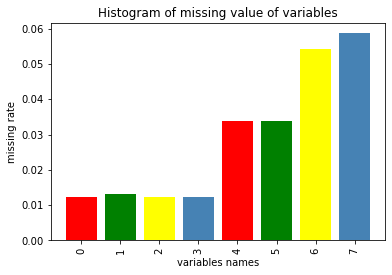

In [12]:
num_cols=['NO_HOLD_QTY','M','U','PT','UP_TIME','EQP_UTIL','TC','CS','AI','C_AI']
missData(df_train)

In [13]:
#df_train['Finish']=np.where(df_train['TOOLG_ID_NEXT'].isnull(), 1, 0).astype(str)
df_train['WEEKDAY']=pd.to_datetime(df_train['MFG_DATE'],format='%Y%m%d').dt.day_name()
 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120018 entries, 0 to 120017
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   MFG_DATE     120018 non-null  int64  
 1   TOOLG_ID     120018 non-null  object 
 2   WIP_QTY      120018 non-null  float64
 3   NO_HOLD_QTY  120018 non-null  float64
 4   MOVE_QTY     120018 non-null  float64
 5   M            118540 non-null  float64
 6   U            118442 non-null  float64
 7   PT           120018 non-null  float64
 8   UP_TIME      118540 non-null  float64
 9   EQP_UTIL     118540 non-null  float64
 10  TC           115972 non-null  float64
 11  CS           115972 non-null  float64
 12  AI           113521 non-null  float64
 13  C_AI         112975 non-null  float64
 14  WEEKDAY      120018 non-null  object 
dtypes: float64(12), int64(1), object(2)
memory usage: 13.7+ MB


In [14]:
pd.to_datetime(df_train['MFG_DATE'],format='%Y%m%d').dt.day_name()

0         Wednesday
1         Wednesday
2         Wednesday
3         Wednesday
4         Wednesday
            ...    
120013     Thursday
120014     Thursday
120015     Thursday
120016     Thursday
120017     Thursday
Name: MFG_DATE, Length: 120018, dtype: object

In [15]:

df_train.head()

,MFG_DATE,TOOLG_ID,WIP_QTY,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,AI,C_AI,WEEKDAY
0,20200122,CI_STI,1672.0,1500.0,3371.0,5.0,0.475904,4910.234940,0.956914,0.989448,0.382283,0.354976,159.375000,0.836586,Wednesday
1,20200122,DGM_AM_350,377.0,324.0,2294.0,10.0,0.707514,4017.560694,0.839097,0.979897,0.264591,0.256043,101.791667,0.629749,Wednesday
2,20200122,DI_PSG,0.0,0.0,125.0,2.0,0.500000,16531.000000,0.986675,0.375072,0.052413,0.298198,12.250000,1.361144,Wednesday
3,20200122,DN_SiN,131.0,125.0,1381.0,4.0,0.782313,2056.897959,0.982981,0.779669,0.477650,0.373563,51.291667,1.101988,Wednesday
4,20200122,DO_SOD,13.0,12.0,706.0,2.0,1.000000,1750.037736,0.909998,0.460758,0.278303,0.183449,25.250000,3.147461,Wednesday


In [16]:
df_train.describe()

,MFG_DATE,WIP_QTY,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,AI,C_AI
count,1.200180e+05,120018.000000,120018.000000,120018.000000,118540.000000,118442.000000,120018.000000,118540.000000,118540.000000,115972.000000,115972.000000,113521.000000,112975.000000
mean,2.020204e+07,665.831217,584.163217,5255.925968,6.548169,0.664630,5872.975754,0.921193,0.624177,0.595742,0.561539,225.856884,2.640577
std,3.308159e+03,1518.844885,1350.837912,15090.027801,8.241060,0.296037,6802.255497,0.120564,0.296448,0.993900,0.997925,644.051553,27.075672
min,2.020012e+07,0.000000,0.000000,0.300000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-362.083333,-1746.889210
25%,2.020050e+07,26.000000,25.000000,235.000000,2.000000,0.430894,2059.140621,0.888972,0.392431,0.260518,0.220116,11.791667,0.816412
50%,2.020081e+07,152.000000,125.000000,834.000000,3.000000,0.671875,3804.761997,0.970585,0.693149,0.400569,0.359979,35.791667,1.542316
75%,2.020112e+07,619.000000,554.000000,2711.875000,8.000000,0.981132,6962.364087,1.000000,0.886909,0.567120,0.526168,112.208333,2.811438
max,2.021022e+07,31335.000000,29847.000000,129006.000000,64.000000,3.000000,96513.000000,1.000000,1.000000,33.466401,33.466401,5440.833333,2581.985283


In [17]:
# 5          M   1478  0.012315
# 6          U   1576  0.013131
# 8    UP_TIME   1478  0.012315
# 9   EQP_UTIL   1478  0.012315
# 10        TC   4046  0.033712
# 11        CS   4046  0.033712
# 12        AI   6497  0.054134
# 13      C_AI   7043  0.058683
#df_train['TOOLG_ID_NEXT'] = df_train['TOOLG_ID_NEXT'].fillna('NA')
# 均值填充
df_train['M'] = df_train['M'].fillna(df_train['M'].mean())
df_train['U'] = df_train['U'].fillna(df_train['U'].mean())
df_train['TC'] = df_train['TC'].fillna(df_train['TC'].mean())
# df_train['CA'] = df_train['CA'].fillna(df_train['CA'].mean())
df_train['CS'] = df_train['CS'].fillna(df_train['CS'].mean())
df_train['AI'] = df_train['AI'].fillna(df_train['AI'].mean())
df_train['C_AI'] = df_train['C_AI'].fillna(df_train['C_AI'].mean())

# 中位数填充
df_train['UP_TIME'] = df_train['UP_TIME'].fillna(df_train['UP_TIME'].median())
df_train['EQP_UTIL'] = df_train['EQP_UTIL'].fillna(df_train['EQP_UTIL'].median())
# 众数填充
from sklearn.impute import SimpleImputer

# imputer = Imputer(missing_values ="NaN",strategy = "most_frequent",axis = 0)
# # imp_mean = SimpleImputer(missing_values = np.nan, strategy="most_frequent",copy=True)
# # df_train_mean = imp_mean.fit_transform(df_train[:'CS'])
# # df_train_mean
# df_train['CS']=imputer.transform(df_train['CS'].reshape(-1,1))
# imputer = SimpleImputer(missing_values ="nan",strategy = "mean")
# df_train['CS']=imputer.fit_transform(df_train['CS'].values.reshape(-1,1))[:0]
imp = SimpleImputer(strategy="most_frequent")
imp.fit_transform(df_train)

print(df_train.describe())
print(df_train.info())
# strategy參數：可為"mean"(平均數[預設])、"median"(中位數)、"most_frequent"(眾數[可用於填充文字])、"constant"(常數[可用於填充文字])
# 若使用"constant"(常數)進行填補，則需再指定fill_value參數為何值
# fill_value = 0：使用0進行填補
# copy: 預設為True:創建特徵矩陣的副本 ; 設為False時，會將缺失值直接填補到原本的特徵矩陣中去
# X_missing

           MFG_DATE        WIP_QTY    NO_HOLD_QTY       MOVE_QTY  \
count  1.200180e+05  120018.000000  120018.000000  120018.000000   
mean   2.020204e+07     665.831217     584.163217    5255.925968   
std    3.308159e+03    1518.844885    1350.837912   15090.027801   
min    2.020012e+07       0.000000       0.000000       0.300000   
25%    2.020050e+07      26.000000      25.000000     235.000000   
50%    2.020081e+07     152.000000     125.000000     834.000000   
75%    2.020112e+07     619.000000     554.000000    2711.875000   
max    2.021022e+07   31335.000000   29847.000000  129006.000000   

                   M              U             PT        UP_TIME  \
count  120018.000000  120018.000000  120018.000000  120018.000000   
mean        6.548169       0.664630    5872.975754       0.921801   
std         8.190159       0.294087    6802.255497       0.119943   
min         1.000000       0.000000       0.000000       0.000000   
25%         2.000000       0.435185    205

In [18]:

# 1. 查看缺失情况
print(df_train.isnull().sum())
# print(df_test.isnull().sum())
#df_train.dropna() # 刪除null值
#df2_test = df2_test.dropna()# 刪除null值


MFG_DATE       0
TOOLG_ID       0
WIP_QTY        0
NO_HOLD_QTY    0
MOVE_QTY       0
M              0
U              0
PT             0
UP_TIME        0
EQP_UTIL       0
TC             0
CS             0
AI             0
C_AI           0
WEEKDAY        0
dtype: int64


In [19]:
#EDA(df_train)

In [22]:
#df_train[['WIP_QTY2']] = df_train['MOVE_QTY']+df_train['WIP_QTY']
df_train[['ToolPrefix', 'ToolSub']] = df_train['TOOLG_ID'].str.split('_', 1, expand=True)
# df_train[['ToolPrefix_NEXT', 'ToolSub_NEXT']] = df_train['TOOLG_ID_NEXT'].str.split('_', 1, expand=True)

In [23]:
df_train = df_train.drop(columns=['MFG_DATE','WIP_QTY']) #'TOOLG_ID',,'TOOLG_ID_NEXT'

In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120018 entries, 0 to 120017
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   TOOLG_ID     120018 non-null  object 
 1   NO_HOLD_QTY  120018 non-null  float64
 2   MOVE_QTY     120018 non-null  float64
 3   M            120018 non-null  float64
 4   U            120018 non-null  float64
 5   PT           120018 non-null  float64
 6   UP_TIME      120018 non-null  float64
 7   EQP_UTIL     120018 non-null  float64
 8   TC           120018 non-null  float64
 9   CS           120018 non-null  float64
 10  AI           120018 non-null  float64
 11  C_AI         120018 non-null  float64
 12  WEEKDAY      120018 non-null  object 
 13  ToolPrefix   120018 non-null  object 
 14  ToolSub      119528 non-null  object 
dtypes: float64(11), object(4)
memory usage: 13.7+ MB


In [25]:
#trainModel(df_train,save_model)


In [26]:
#TestModel(df_train,save_model)

In [27]:
# newdf = pd.DataFrame(np.repeat(df.values,3,axis=0))
# newdf.columns = df.columns
# print(newdf)


In [28]:
df_testing =df_train_orign
df_train.columns
df_train.mean()
cols=['NO_HOLD_QTY','M','U','PT','UP_TIME','EQP_UTIL','TC','CS','AI','C_AI']
df_testing[cols] = df_train[cols].mean()
df_testing.head()
df_train_orign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120018 entries, 0 to 120017
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   MFG_DATE     120018 non-null  int64  
 1   TOOLG_ID     120018 non-null  object 
 2   WIP_QTY      120018 non-null  float64
 3   NO_HOLD_QTY  120018 non-null  float64
 4   MOVE_QTY     120018 non-null  float64
 5   M            120018 non-null  float64
 6   U            120018 non-null  float64
 7   PT           120018 non-null  float64
 8   UP_TIME      120018 non-null  float64
 9   EQP_UTIL     120018 non-null  float64
 10  TC           120018 non-null  float64
 11  CS           120018 non-null  float64
 12  AI           120018 non-null  float64
 13  C_AI         120018 non-null  float64
 14  WEEKDAY      120018 non-null  object 
 15  ToolPrefix   120018 non-null  object 
 16  ToolSub      119528 non-null  object 
dtypes: float64(12), int64(1), object(4)
memory usage: 15.6+ MB


In [29]:
# 'CI_STI', 'DGM_AM_350', 'DI_PSG', 'DN_SiN', 'DO_SOD', 'DS_Logic',
#        'DT_BP_G/F', 'DT_O3', 'EA_AsherM', 'EC_1C', 'EC_DK_2F', 'EC_DK1',
#        'EC_Flex45_1C', 'EG_LAM_G2', 'EG_PolyEB_CIS', 'EG_PolyEB2',
#        'EH_OxEB', 'EK_1G', 'EK_aC', 'CI_ILD', 'CI_IMD', 'DA_BM', 'DB_Pre',
#        'DB_TiN', 'DGA_BM_350', 'DI_HDP', 'DK_300', 'DK_550', 'DK_SiN',
#        'DM_TiN(ASFD)', 'DR_LampA', 'DT_STI_TD', 'DW_WSi', 'EA_RWK',
#        'EB_Asher', 'EC_DK2', 'EC_Flex_38', 'EC_Flex45_F6X', 'EK_aC(JX)',
#        'EK_C/F', 'EK_RG', 'EU_Jin_Cu', 'EU_V_Cu', 'EW_3S', 'FAFS_Annl',
#        'FD_BS', 'FD_DO', 'FL_NiPt', 'FN_HTO_DK', 'IBH_HiCur', 'IBS_As(H)',
#        'ID_HiEnrg', 'MA_Al_175', 'MP_Cu', 'MR_Cu_TD', 'MS_MOCVD',
#        'MT_Ti/TiN', 'EC_LDD_Logic', 'EC_Shin_DK40', 'EC_TH_63',
#        'EC_Via_20', 'EC_Via_30', 'EC_Via_40', 'EG_Gate_232', 'EG_STI_G5',
#        'EH_CP', 'EH_LDD_2N', 'EK_1G_6X', 'EM_AL_Cln', 'EM_AL_FDY',
#        'EM_MX_W/O', 'EM_SP55_TM', 'EW_1G', 'EW_BL', 'EW_CP_72',
#        'EW_RG_63', 'PE_ChaEsr', 'PG_UVcure', 'PH_Immersion', 'QC_ET',
#        'QE_ThkMea', 'QH_XRF', 'QP_Defect', 'QS_SEM', 'RI_AM', 'SC_M.Jet',
#        'WAT_TSA', 'WDD_160_G1', 'WDD_160_G2', 'WDS_160_G2', 'WE_HV40',
#        'WK_BsEtch', 'WK_Cu', 'WM_PosCln', 'WN_ContactCln', 'FD_Tel',
#        'FE_Anneal', 'FG_GOX', 'FH_HT(L)', 'FJ_TD', 'FK_ZAC', 'FL_LT',
#        'FM_ALD', 'FM_ALD_SPT', 'FM_SiN(F)', 'FO_TiO', 'FT_119',
#        'FX_PadOxi_B', 'IBS_HiCur', 'IBV_HiCur', 'MT_TiN', 'PK_DUVKrF',
#        'PU_C/F', 'PU_I-Line', 'CU_Cu', 'DA_AM', 'DB_Ti/SFD', 'DB_Ti/TiN',
#        'DC_DCT', 'DC_WCVD', 'DD_BD_Cu', 'DGA_AM_230_LTO', 'DGA_AM_350',
#        'DGA_AM_400', 'DM_SFD_480', 'DP_SiN', 'DS_FDY', 'DS_HDP', 'DT_BP',
#        'DT_STI', 'EC_3S', 'EC_DK_1G', 'EC_Flex', 'CI_ILD_Eba',
#        'CI_STI_Eba', 'CM_W_Eba', 'CM_WCMP', 'CN_N2_Cu', 'DB_Ti',
#        'DD_BLOK_Cu', 'DM_SFD_650', 'EA_C/F', 'EC_LDD_Dram', 'EC_LDD_NXP',
#        'EC_SAC', 'EC_TH_CIS', 'EG_LAM_Poly', 'EH_PV', 'EH_SR', 'EK_1F_68',
#        'EK_1G_SDRM', 'EK_RG_SDRM', 'PW_PIX', 'QA_ADI', 'QA_AEI', 'QA_Cu',
#        'QC_CMP', 'QGK_2365', 'QX_Overly', 'QY_D.PC', 'RD_RTO', 'SC_C/F',
#        'WC_Crown', 'WD_130', 'WE_Crown', 'WO_SiO2', 'WQ_CeO2', 'WW_Poly',
#        'XE_C/F', 'EL_Light_2B', 'EM_AL_Depo', 'EM_MX', 'EM_W/O',
#        'EU_TU_Cu', 'EV_BV_AM', 'EV_BV_BM', 'EW_1GBL', 'EW_2S_G5', 'EW_CP',
#        'EW_SP(G5)', 'FD_B-Poly', 'FD_TD', 'FE_DK', 'FJ_MLD_OX',
#        'FK_LAZO(I)', 'FN_HTO', 'FN_SiN(DRAM)', 'FP_NDPoly', 'FQ_PIQ',
#        'MA_Alps', 'MB_Co(H)', 'MB_Co_350', 'MB_PC30', 'MR_Cu', 'PB_BARC',
#        'PT_Marker', 'QC_C/F', 'QC_TF', 'QPK_PUMA', 'QW_Cu', 'QW_SEM-ET',
#        'RAM_RTA', 'RDA_RTO', 'RE_EPI_ND', 'RI_BM', 'RN_RTN_5P/2N',
#        'WA_PreCln', 'WAT Out', 'WAT_TEST', 'WF_DK28', 'WF_LiEtch',
#        'WH_CIS', 'WH_EKC', 'WJ_LiEtch', 'WM_PreCln', 'WN_NiPt',
#        'WU_W-RMV', 'WW_HF', 'EC_Flex_45', 'EC_TH_45', 'EC_Via(S55)',
#        'EG_C/F', 'EG_LAM_G1', 'EG_LDD', 'EG_PolyEB', 'EG_SiN EB',
#        'EG_STI_232', 'EG_STI_DPS', 'EH_LDD_SP', 'EH_PI', 'EK_1G05_68',
#        'EL_Light', 'EM_AL_AG', 'EN_1F', 'EU_U_Cu', 'EW_4F', 'EW_RG_45',
#        'WN_Co-RMV', 'WO_NXP', 'WT_Cu', 'WW_NH4OH', 'WY_DK', 'XE_Cu',
#        'XE_Sorter', 'XW_Sorter', 'EW_SP(G2)', 'FC_PadOxi', 'FD_Ge-Poly',
#        'FH_HT', 'FH_HT_LCD', 'FI_WHoxid', 'FK_LAHO', 'FK_LAZO(F)',
#        'FL_Cu', 'FM_SiN(A)', 'FN_H(F)', 'FN_SiN(A)', 'FN_SiN(F)',
#        'FT_148', 'FT_TEOS(F)', 'IA_MidCur', 'MA_Al', 'MB_Co_250',
#        'MS_SIP', 'MW_W', 'OTHERS', 'PH_DUVArF', 'PR_Relacs', 'PW_C/F',
#        'QA_C/F', 'QC_Cu', 'QF_Wet', 'QG_Defect', 'QU_Mfilm', 'QW_C/F',
#        'QW_SEM-PH', 'QZ_Defect', 'RAA_RTA', 'RAA_Spike', 'RAM_Anneal',
#        'RN_RTN_1G', 'RS_DK', 'RS_SPA', 'WB_LiEtch', 'WC_SiO2',
#        'WE_PreCln', 'WH_DSP', 'WL_Resist', 'EC_Flex45_F7X', 'EM_W/I',
#        'RS_TD', 'WDD_SP55', 'MS_NiPt', 'QY_Defect', 'RE_EPI',
#        'FT_TEOS(TD)', 'DR_NiPt', 'DD_BD_TD', 'WK_NiPt', 'EW_3SCP',
#        'EK_1F_99', 'EC_SCCM_SiNEB', 'EW_2S_DPS', 'DC_WCVD_Cu',
#        'EC_Flex(S90)', 'EC_Con', 'RAA_DK', 'EC_SADP_DK28',
#        'FI_Whoxid(TD)', 'EK_BL20', 'DK_Li filter', 'FM_ALD(TD)',
#        'EC_HV40', 'CP TEST', 'WT Out', 'RS_S55', 'DI_TD', 'DL_TD',
#        'WM_SW', 'QD_AFM', 'EK_a-C_S', 'WR_PD_B(NPW)', 'EC_HMO',
#        'QV_CVTest', 'QP_PUMA', 'DK_Li Pi', 'EW_RG', 'EA_TD', 'EC_HARC',
#        'EK_1S_TD', 'D63FE01A', 'WR_PD_A(NPW)', 'FN_NPW', 'CI_C/F',
#        'FD_TD(T92)', 'WH_C/F', 'WH_TD', 'FD_TD(K59)', 'WG_Si', 'MS_Ta2O5',
#        'QG_2365', 'DC_400', 'EG_LAM_G3', 'PR_1B', 'FH_H88', 'EW_DK28',
#        'DI_HDP_HV80', 'DI_HDP_FSG', 'WF_Certas'

In [69]:
toolgCorr=[]
for toolg in df_train_orign.TOOLG_ID.unique() :
    df_train_orign_tool = df_train_orign.loc[df_train_orign['TOOLG_ID']==toolg]
    if(df_train_orign_tool['WIP_QTY'].corr(df_train_orign_tool['MOVE_QTY']) >0.7):
        toolgCorr.append([toolg,df_train_orign_tool['WIP_QTY'].corr(df_train_orign_tool['MOVE_QTY'])])
    # print(toolg ,' corr : ',df_train_orign_tool['WIP_QTY'].corr(df_train_orign_tool['MOVE_QTY']))
toolgCorr =np.asarray(toolgCorr) 
# toolgCorr[:,1]
 


In [70]:
toolgCorr 

array([['EC_Flex_38', '0.7911504844531038'],
       ['EK_C/F', '0.7093350967839047'],
       ['FN_HTO_DK', '0.8118970940213679'],
       ['WE_HV40', '0.8394352215981518'],
       ['FE_Anneal', '0.7061817068258882'],
       ['FK_ZAC', '0.7416137157692824'],
       ['FL_LT', '0.8332026854057203'],
       ['FM_ALD', '0.767263250582651'],
       ['FM_ALD_SPT', '0.7439758436083826'],
       ['FO_TiO', '0.7585485117665615'],
       ['EK_RG_SDRM', '0.711698041268659'],
       ['SC_C/F', '0.872936406656076'],
       ['WW_Poly', '0.7351470441147052'],
       ['FE_DK', '0.7165982592764932'],
       ['FL_Cu', '0.7182510360970699'],
       ['PW_C/F', '0.7348233604994369'],
       ['EC_SADP_DK28', '0.7182303869168956'],
       ['FI_Whoxid(TD)', '0.8044510065896284'],
       ['EC_HMO', '0.7067499621544588'],
       ['EW_RG', '0.7253702014905449'],
       ['MS_Ta2O5', '0.7240866868203919']], dtype='<U18')

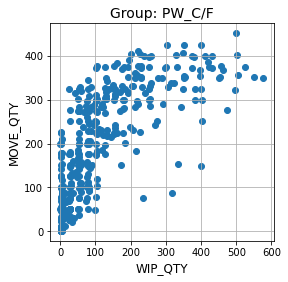

In [72]:
# df_train_orign.TOOLG_ID.unique()
keyTool=['PW_C/F']
# for toolg in df_train_orign.TOOLG_ID.unique() :
for toolg in keyTool :
    df_train_orign_toolg = df_train_orign.loc[df_train['TOOLG_ID']==toolg]
    fig, ax = plt.subplots(figsize=(4,4))
    ax.scatter(x=df_train_orign_toolg['WIP_QTY'], y=df_train_orign_toolg['MOVE_QTY'])
    #            c=gp['id'], cmap='tab20')
    
    ax.grid()
    ax.set_ylabel('MOVE_QTY', fontsize=12)
    ax.set_xlabel('WIP_QTY', fontsize=12)
    ax.set_title(f'Group: {toolg}', fontsize=14)
    
plt.show()

# import matplotlib.pyplot as plt

# data = df_plot.melt(id_vars=['MOVE_QTY', 'WIP_QTY'])

# for idx, gp in data.groupby('group'):
#     fig, ax = plt.subplots(figsize=(4,4))
#     ax.scatter(x=gp['variable'], y=gp['value'],
#                c=gp['id'], cmap='tab20')
    
#     ax.grid()
#     ax.set_ylabel('Value', fontsize=12)
#     ax.set_xlabel('Months', fontsize=12)
#     ax.set_title(f'Group: {idx}', fontsize=14)
    
#     plt.show()

In [46]:
#df_train_orign.TOOLG_ID.unique()